In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, v_measure_score

In [3]:
import os
import math
from pathlib import Path
import re
import collections

In [4]:
docs_meta_path = Path("out/PreprocessedTextsMeta/decoded_documents_metadata.csv")

In [5]:
docs_meta_df = pd.read_csv(docs_meta_path)
print("Columns:", docs_meta_df.columns)
print("#:", len(docs_meta_df))

Columns: Index(['doc_id', 'xml_path', 'text_doc_path', 'eebo_id', 'estc_number',
       'title', 'author', 'publisher', 'date', 'pubplace'],
      dtype='object')
#: 1466


## Parse year

In [47]:
def parse_date(raw_date_str):
    m = re.search(r"(\d{4})", raw_date_str)
    if m:
        return int(m.group(1))
    else:
        return None
docs_meta_df['pub_year'] = docs_meta_df['date'].apply(parse_date)
print("Known year percent:", 100 * (1 - docs_meta_df['pub_year'].isna().sum() / len(docs_meta_df)))

Known year percent: 99.86357435197817


## Parse author

In [20]:
def find_author_abbreviation(author_str):
    m = re.search(r"\W([a-z]+\.)", author_str)
    return m.group(1) if m else None

abbrevs = docs_meta_df['author'].astype(str).apply(find_author_abbreviation)

In [21]:
abbrevs.unique()

array(['d.', 'ca.', 'cent.', None, 'de.', 'b.', 'name.', 'fl.',
       'publisher.', 'van.', 'colonist.', 'etc.', 'thence.',
       'republique.', 'quality.', 'gent.', 'campaign.', 'retinue.',
       'kingdoms.', 'merchant.', 'gentleman.', 'translator.',
       'shipbuilder.', 'county.', 'author.', 'sailor.', 'worth.',
       'physician.'], dtype=object)

In [42]:
def parse_author(author_str):
    author_str = re.sub(r"\W([a-z]+\.)", "", author_str)
    author_str = re.sub(r"\d+(?:th|nd|st)", "", author_str)
    author_str = re.sub(r"[^a-zA-Z\s]", "", author_str)
    author_str = author_str.replace("  ", " ")
    author_str = author_str.lower().strip()
    return author_str
print("% unknown authors:", 100 * docs_meta_df['author'].isna().sum() / len(docs_meta_df))
print("# unique authors after parsing:", len(docs_meta_df['author'].astype(str).apply(parse_author).unique()))

% unknown authors: 39.631650750341066
# unique authors after parsing: 568


In [44]:
authors_parsed = docs_meta_df['author'].astype(str).apply(parse_author)
authors_parsed_counter = collections.Counter(authors_parsed)
#plt.pie(authors_parsed_counter.values(), labels=authors_parsed_counter.keys(), autopct='%1.1f%%')
[t for t in sorted(zip(authors_parsed_counter.values(), authors_parsed_counter.keys()), reverse=True) if t[0] >= 5]

[(581, 'nan'),
 (41, 'england and wales parliament'),
 (23, 'england and wales'),
 (21, 'england and wales sovereign  charles ii'),
 (20, 'england and wales sovereign  charles i'),
 (15, 'scotland privy council'),
 (12, 'taylor john'),
 (11, 'england and wales sovereign  james i'),
 (8, 'ward edward'),
 (8, 'ogilby john'),
 (8, 'butter nathaniel'),
 (7, 'penn william'),
 (7, 'mather cotton'),
 (7, 'england and wales sovereign  elizabeth i'),
 (7, 'company of scotland trading to africa and the indies'),
 (6, 'united provinces of the netherlands staten generaal'),
 (6, 'r b'),
 (6, 'mandeville john sir'),
 (5, 'smith john'),
 (5, 'howell james'),
 (5, 'camden william')]

# Clustering

## Cluster by topics

In [71]:
# Download from shared drive if not exists
doc_topics_csv_path = Path("vectors_in_csv/plsi_vectors_20250409_reweighted/PLSI_P_dz_20topics_120iter_tfidf_reweighted_count_vectors.csv")
doc_topics_df = pd.read_csv(doc_topics_csv_path)
n_topics = doc_topics_df.shape[1]
print(f"{doc_topics_df.shape=}")

doc_topics_df.shape=(1466, 20)


Text(0.5, 1.0, 'Document clusters using pLSI embeddings')

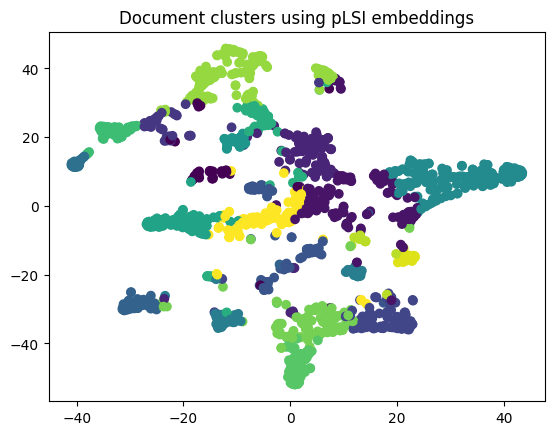

In [80]:
kmeans = KMeans(n_clusters=n_topics, random_state=344)
doc_clusters = kmeans.fit_predict(doc_topics_df)
tsne = TSNE(n_components=2)
docs_embeddings_2d = tsne.fit_transform(doc_topics_df)
plt.scatter(docs_embeddings_2d[:, 0], docs_embeddings_2d[:, 1], c=doc_clusters)
plt.title("Document clusters using pLSI embeddings")

In [89]:
doc_clusters_maxtopic = np.argmax(doc_topics_df, axis=1)

array([19,  1, 16, ...,  8,  7, 19], shape=(1466,))

## Cluster by year

#bins: 25


Text(0.5, 1.0, 'Published years')

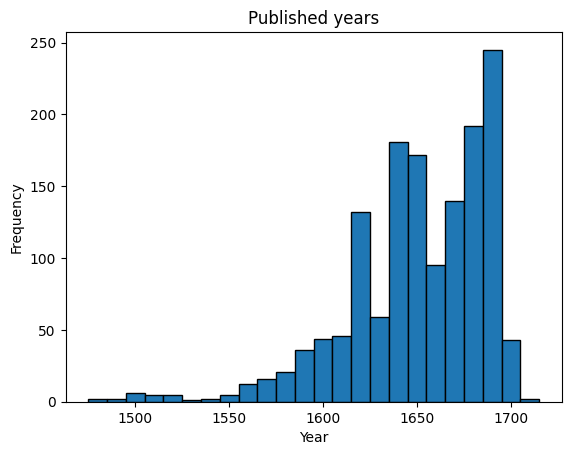

In [62]:
years_binsize = 10
years_data = docs_meta_df['pub_year']
bins = np.arange(min(years_data), max(years_data) + years_binsize, years_binsize)
print("#bins:", len(bins))
years_hist_counts, years_hist_bin_edges = np.histogram(years_data, bins=bins)
plt.bar(years_hist_bin_edges[:-1], years_hist_counts, width=years_binsize, edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Published years')

In [81]:
years_bin_indices = np.digitize(years_data, bins) - 1
years_quantized = bins[years_bin_indices]
years_quantized = years_quantized.astype(int)
display(years_quantized)

array([1510., 1520., 1550., ..., 1680., 1670., 1690.], shape=(1466,))

In [46]:
docs_meta_df.columns

Index(['doc_id', 'xml_path', 'text_doc_path', 'eebo_id', 'estc_number',
       'title', 'author', 'publisher', 'date', 'pubplace'],
      dtype='object')

Text(120.72222222222221, 0.5, 'Dominant Topic')

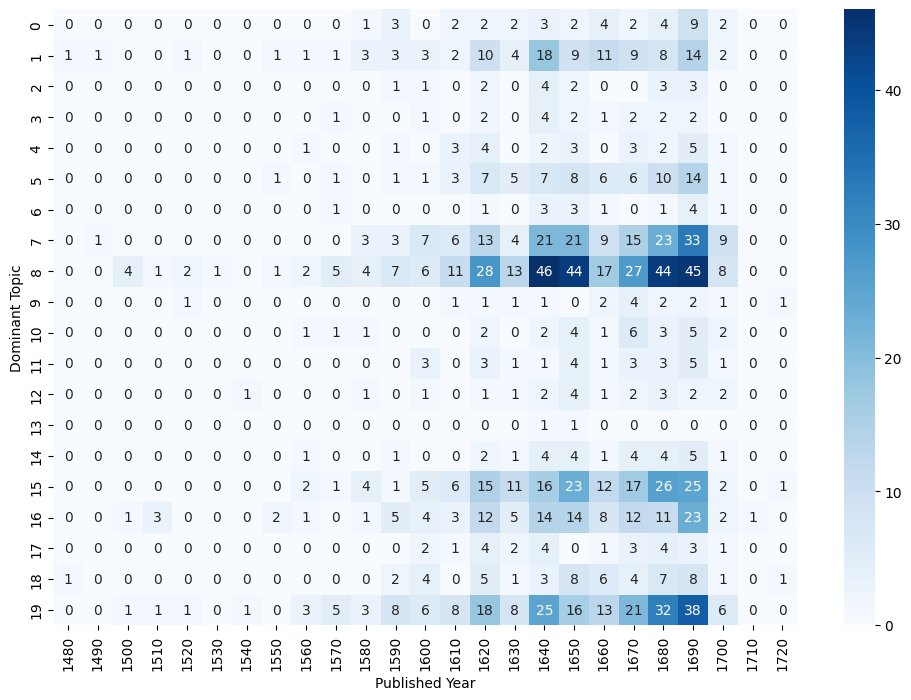

In [93]:
years_cluster_table = pd.crosstab(doc_clusters_maxtopic, years_quantized)
years_cluster_table.columns = years_cluster_table.columns.astype(int)
plt.figure(figsize=(12, 8))
sns.heatmap(years_cluster_table, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.xlabel("Published Year")
plt.ylabel("Dominant Topic")

In [92]:
years_cluster_table

col_0,1480.0,1490.0,1500.0,1510.0,1520.0,1530.0,1540.0,1550.0,1560.0,1570.0,...,1630.0,1640.0,1650.0,1660.0,1670.0,1680.0,1690.0,1700.0,1710.0,1720.0
row_0,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,2,3,2,4,2,4,9,2,0,0
1,1,1,0,0,1,0,0,1,1,1,...,4,18,9,11,9,8,14,2,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,4,2,0,0,3,3,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,4,2,1,2,2,2,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,2,3,0,3,2,5,1,0,0
5,0,0,0,0,0,0,0,1,0,1,...,5,7,8,6,6,10,14,1,0,0
6,0,0,0,0,0,0,0,0,0,1,...,0,3,3,1,0,1,4,1,0,0
7,0,1,0,0,0,0,0,0,0,0,...,4,21,21,9,15,23,33,9,0,0
8,0,0,4,1,2,1,0,1,2,5,...,13,46,44,17,27,44,45,8,0,0


In [ ]:
# Plot visualization - top_words.txt
def parse_topic_blocks(filename):
    with open(filename, 'r') as file:
        content = file.read()

    # Split on each topic block
    raw_blocks = re.split(r'######## Topic (\d+) ########', content)
    
    topics_data = []
    # raw_blocks will look like: ['', '0', '<block0>', '1', '<block1>', ...]
    for i in range(1, len(raw_blocks), 2):
        topic_num = raw_blocks[i]
        block = raw_blocks[i + 1]
        words = re.findall(r'\s*\d+\s+\|\s+([a-zA-Z0-9_]+)\s+\|\s+([\d.]+)', block)
        top_words = words[:10]
        word_list = [word for word, val in top_words]
        val_list = [float(val) for word, val in top_words]
        topics_data.append((f"Topic {topic_num}", word_list, val_list))

    return topics_data

def plot_word_distributions(topics_data):
    topics_per_page = 10
    num_pages = (len(topics_data) + topics_per_page - 1) // topics_per_page

    for page in range(num_pages):
        fig, axs = plt.subplots(2, 5, figsize=(20, 8))
        axs = axs.flatten()
        start_idx = page * topics_per_page
        end_idx = start_idx + topics_per_page

        for idx, (title, words, values) in enumerate(topics_data[start_idx:end_idx]):
            ax = axs[idx]
            ax.bar(words, values, color='skyblue')
            ax.set_title(title)
            ax.set_xticklabels(words, rotation=45, ha='right', fontsize=8)
            ax.set_ylabel("P")
        
        for j in range(idx + 1, len(axs)):
            fig.delaxes(axs[j])  # Remove unused subplots

        plt.tight_layout()
        fig_save_path = f"word_distribution_page_{page + 1}.png"
        print(f"Saving word distribution figure to: {fig_save_path}")
        plt.savefig(fig_save_path)
        plt.show()

filename = Path("vectors_in_csv/plsi_txt_reports_20topics_reweighted/vis-t20-i120-weighted/top_words.txt")
topics = parse_topic_blocks(filename)
plot_word_distributions(topics)